In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "/O2 /fp:fast /openmp")

S = 512

def transpose(A):
    N, M = A.shape
    i, j = tf.indices([M, N])
    return A[j, i] * 1.0

def matmul():
    A = tf.input([-1, -1], tf.float32)
    N, M = A.shape
    B = tf.input([M, -1], tf.float32)
    K = B.shape[1]
        
    Bt = transpose(B)
        
    #C = tf.zeros([N, K])
    #i, j, k = tf.indices([N, K, M])
    #tf.scatterAdd(C[i, j], A[i, k] * Bt[j, k])
        
    C = tf.buffer([N, K])
        
    i, j = C.indices
        
    s = tf.zeros([N, K], tf.float32)
    def loop_body(k):
        s.set(s + A[i, k] * Bt[j, k])
         
    tf.loop(loop_body, 0, M, 1)
        
    C[i, j] = s
        
    return [C]

mmul = tf.compile(matmul)

TensorFrost module loaded!
TensorProgram:
  Kernel count: 2
  Intermediate buffers: 5
  Lines of generated code: 255
  IR size: 78



In [2]:
Anp = np.random.rand(64, 32).astype(np.float32)
Bnp = np.random.rand(32, 48).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)

Cerror = np.linalg.norm(Cnp - Cnp2) / np.linalg.norm(Cnp2)
print("Error:", Cerror)


[[ 7.0739074  6.70188    7.9605093 ...  5.332518   7.586759   7.8210063]
 [ 9.750481  10.8297415 11.39551   ...  8.590492  11.005639  10.39423  ]
 [ 8.708384   7.7053375  8.930585  ...  7.367649   8.863281   7.494631 ]
 ...
 [ 9.348464   8.737545   8.729408  ...  7.1260767  9.4447565  8.609997 ]
 [ 7.434928   6.7700105  7.903011  ...  5.7752814  8.044277   6.714461 ]
 [ 8.422988   7.348839   8.756398  ...  6.4697776  8.033096   7.985263 ]]
[[ 7.073906   6.7018795  7.9605093 ...  5.3325186  7.5867596  7.8210077]
 [ 9.750481  10.829741  11.39551   ...  8.590491  11.005639  10.394232 ]
 [ 8.708384   7.7053375  8.930584  ...  7.3676486  8.863281   7.494632 ]
 ...
 [ 9.348463   8.737545   8.729408  ...  7.126077   9.4447565  8.609997 ]
 [ 7.434927   6.7700105  7.9030104 ...  5.7752824  8.044278   6.7144613]
 [ 8.422989   7.348839   8.756399  ...  6.4697785  8.033095   7.985264 ]]
Error: 6.5093346e-08


In [3]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)

def TestFunc(f1, max_time):
    t0 = time.time()
    i = 0
    while time.time() - t0 < max_time:
        f1()
        i += 1
    return (time.time() - t0) / i

# Performance test
def TensorFrost():
    C, = mmul(A, B)

def Numpy():
    Cnp2 = Bnp @ Anp

np_time = TestFunc(Numpy, 10)
print("Numpy: ", np_time)

tf_time = TestFunc(TensorFrost, 10)
print("TensorFrost: ", tf_time)

print("TF/NP: ", tf_time / np_time)

Numpy:  0.0011097942469136166
TensorFrost:  0.014479386996256805
TF/NP:  13.046911205860523


In [4]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.tensor(Anp)
    B = tf.tensor(Bnp)

    # Performance test
    def TensorFrost():
        C, = mmul(A, B)
    
    def Numpy():
        Cnp2 = Bnp @ Anp

    tf_time = TestFunc(TensorFrost, 1)
    np_time = TestFunc(Numpy, 1)

    return tf_time, np_time

sizes = [2**i for i in range(4, 12)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

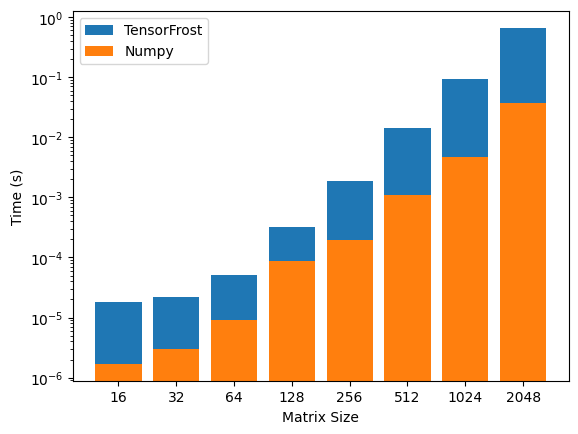

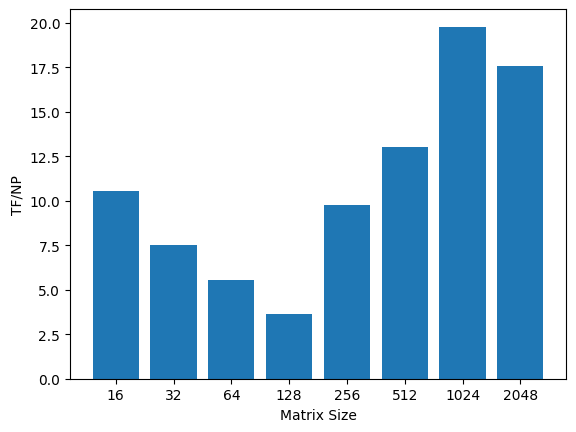

[1.7901220749611224e-05, 2.2410679060000752e-05, 5.106268383856997e-05, 0.0003229361183801876, 0.00187991886604123, 0.014371425764901297, 0.09209082343361595, 0.6600805521011353]
[1.6931442230908838e-06, 2.9722733365491867e-06, 9.193717067167701e-06, 8.878842420580542e-05, 0.00019229129715742983, 0.001101576546740427, 0.004653034653774528, 0.03755202999821416]


In [5]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)